# TensorFlow Machine Learning with Financial Data

This solution presents an accessible, non-trivial example of machine learning with financial time series.

Time series are an essential part of financial analysis. Today, you have more data at your disposal than ever, more sources of data, and more frequent delivery of that data. New sources include new exchanges, social media outlets, and news sources. The frequency of delivery has increased from tens of messages per second 10 years ago, to hundreds of thousands of messages per second today. Naturally, more and different analysis techniques are being brought to bear as a result. Most of the modern analysis techniques aren't different in the sense of being new, and they all have their basis in statistics, but their applicability has closely followed the amount of computing power available. The growth in available computing power is faster than the growth in time series volumes, so it is possible to analyze time series today at scale in ways that weren't previously practical.

In particular, machine learning techniques, especially deep learning, hold great promise for time series analysis. As time series become more dense and many time series overlap, machine learning offers a way to separate the signal from the noise, even when the noise can seem overwhelming. Deep learning holds great potential because it is often the best fit for the seemingly random nature of financial time series.

In this solution, you will:

* Obtain data for a number of financial markets.
* Munge that data into a usable format and perform exploratory data analysis in order to explore and validate a premise.
* Use TensorFlow to build, train and evaluate a number of models for predicting what will happen in financial markets

You'll perform the entire investigation in this notebook running on an IBM Power8-based "Minsky" system with a proprietary NV-Link connected NVIDIA P-100 GPU.

**Important:** This solution is intended to illustrate the capabilities of Nimbix and TensorFlow for fast, interactive, iterative data analysis and machine learning. It does not offer any advice on financial markets or trading strategies. The scenario presented in the tutorial is an example. Don't use this code to make investment decisions.

## The premise

The premise is straightforward: financial markets are increasingly global, and if you follow the sun from Asia to Europe to the US and so on, you can use information from an earlier time zone to your advantage in a later time zone.

The following table shows a number of stock market indices from around the globe, their closing times in Eastern Standard Time (EST), and the delay in hours between the close that index and the close of the S&P 500 in New York. This makes EST the base time zone. For example, Australian markets close for the day 15 hours before US markets close. If the close of the All Ords in Australia is a useful predictor of the close of the S&P 500 for a given day we can use that information to guide our trading activity. Continuing our example of the Australian All Ords, if this index closes up and we think that means the S&P 500 will close up as well then we should either buy stocks that compose the S&P 500 or, more likely, an ETF that tracks the S&P 500. In reality, the situation is more complex because there are commissions and tax to account for. But as a first approximation, we'll assume an index closing up indicates a gain, and vice-versa.

|Index|Country|Closing Time (EST)|Hours Before S&P Close|
|---|---|---|---|
|[All Ords](https://en.wikipedia.org/wiki/All_Ordinaries)|Australia|0100|15|
|[Nikkei 225](https://en.wikipedia.org/wiki/Nikkei_225)|Japan|0200|14|
|[Hang Seng](https://en.wikipedia.org/wiki/Hang_Seng_Index)|Hong Kong|0400|12|
|[Nifty 50](https://en.wikipedia.org/wiki/NIFTY_50)|India|0600|10|
|[DAX](https://en.wikipedia.org/wiki/DAX)|Germany|1130|4.5|
|[NYSE Composite](https://en.wikipedia.org/wiki/NYSE_Composite)|US|1600|0|
|[Dow Jones Industrial Average](https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average)|US|1600|0|
|[S&P 500](https://en.wikipedia.org/wiki/S%26P_500_Index)|US|1600|0|

## Set up

First, import necessary libraries.

In [1]:
import StringIO

import pandas as pd
from pandas.tools.plotting import autocorrelation_plot
from pandas.tools.plotting import scatter_matrix

import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf

%matplotlib inline

## Get the data

The data covers roughly the last 20 years, using the maximum date range. Data comes from the S&P 500 (S&P), NYSE, Dow Jones Industrial Average (DJIA), Nikkei 225 (Nikkei), Nifty 50 (Nifty), Hang Seng, DAX, and All Ordinaries (AORD) indices.

This data is publicly available and is stored in Nimbix for convenience. The notebook utilizes code to pull data from this store and create a Pandas dataframe for further processing.

## Munge the data

In the first instance, munging the data is straightforward. The closing prices are of interest, so for convenience extract the closing prices for each of the indices into a single Pandas DataFrame, called closing_data. Because not all of the indices have the same number of values, mainly due to bank holidays, we'll forward-fill the gaps. This means that, if a value isn't available for day N, fill it with the value for another day, such as N-1 or N-2, so that it contains the latest available value.

In [2]:
import os
import glob
import datetime

In [3]:
closing_data = pd.DataFrame()
path = "./data/"

for filename in glob.glob(os.path.join(path,'*.csv')):
    #print filename
    indx_name = filename.split('_')[1].split('.')[0].lower()
    indx_name += '_close'
    #print indx_name
    df_data = pd.read_csv(filename, sep=',', header=0).set_index('Date')
    #print df_data
    closing_data[indx_name]=df_data['Close']
#print closing_data


In [4]:
# Pandas includes a very convenient function for filling gaps in the data.
closing_data = closing_data.dropna(how='any')

At this point, you've sourced time series data for 7 financial indices, combined the pertinent data into a single data structure, and harmonized the data to have the same number of entries, by using only the ~20 lines of code in this notebook. Plus, it took about next to no time to do all of that.

## Exploratory data analysis

Exploratory Data Analysis (EDA) is foundational to working with machine learning, and any other sort of analysis. EDA means getting to know your data, getting your fingers dirty with your data, feeling it and seeing it. The end result is you know your data very well, so when you build models you build them based on an actual, practical, physical understanding of the data, not assumptions or vaguely held notions. You can still make assumptions of course, but EDA means you will understand your assumptions and why you're making those assumptions. 

First, take a look at the data.

In [5]:
closing_data.sort_index(ascending=True,inplace=True)

In [6]:
closing_data.describe()

,aord_close,snp_close,hangseng_close,nyse_close,nikkei_close,djia_close,dax_close
count,6004.000000,6004.000000,6004.000000,6004.000000,6004.000000,6004.000000,6004.000000
mean,3655.397917,1135.648133,15054.439090,6467.182694,15082.659873,9896.451036,5292.486569
std,1385.323914,480.385715,6250.208748,2603.532348,4336.106817,4254.864726,2654.609054
min,1204.500000,311.489990,2965.000000,1807.790039,7054.979980,2470.300049,1322.699951
25%,2499.700012,803.639984,9994.857178,4594.817504,10952.434815,7270.592652,2959.867493
50%,3358.199951,1155.005005,14037.430176,6608.984863,15564.854981,10333.300293,5199.790039
75%,4910.650025,1392.352508,20930.817383,8293.784912,18136.913086,12302.482422,6970.859985
max,6853.600098,2298.370117,31638.220703,11339.059570,27147.000000,20093.779297,12374.730469


You can see that the various indices operate on scales differing by orders of magnitude. It's best to scale the data so that, for example, operations involving multiple indices aren't unduly influenced by a single, massive index.

Plot the data.

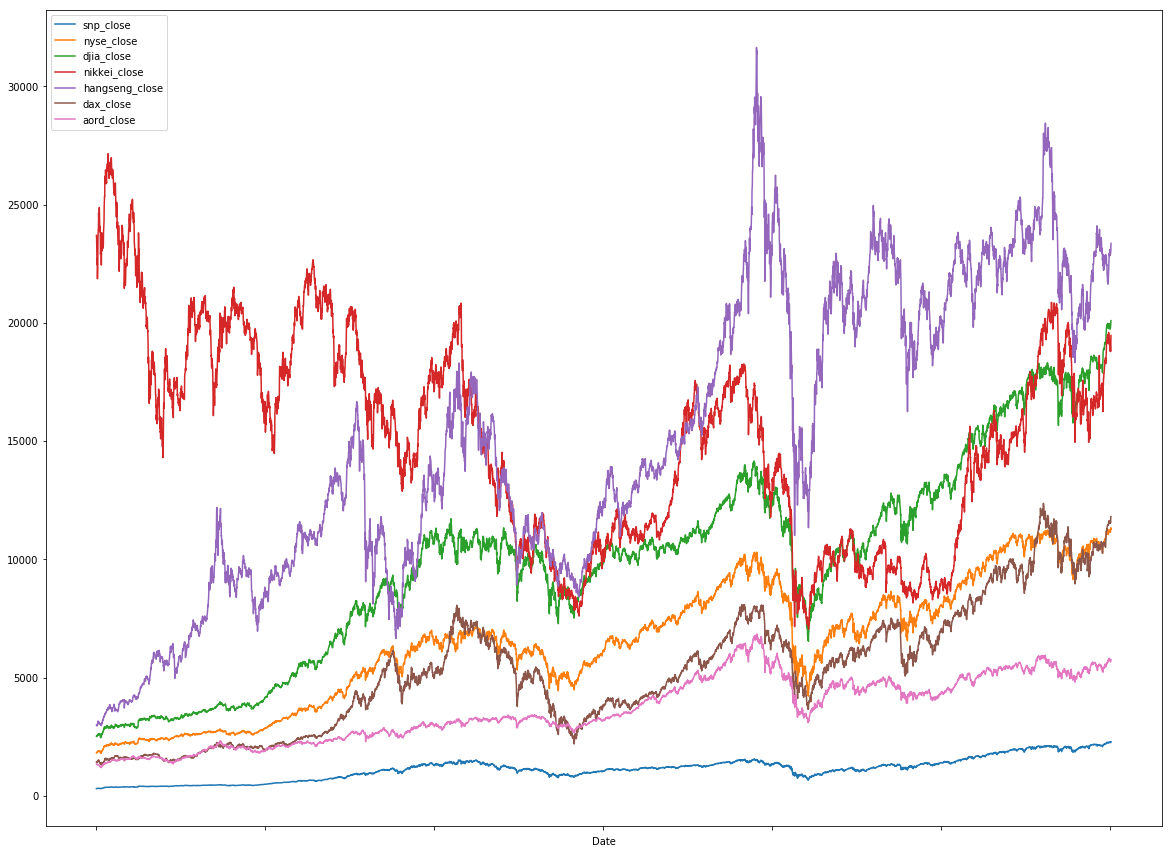

In [7]:
# N.B. A super-useful trick-ette is to assign the return value of plot to _ 
# so that you don't get text printed before the plot itself.

_ = pd.concat([closing_data['snp_close'],
  closing_data['nyse_close'],
  closing_data['djia_close'],
  closing_data['nikkei_close'],
  closing_data['hangseng_close'],
  #closing_data['ftse_close'],
  closing_data['dax_close'],
  closing_data['aord_close']], axis=1).plot(figsize=(20, 15))

As expected, the structure isn't uniformly visible for the indices. Divide each value in an individual index by the maximum value for that index., and then replot. The maximum value of all indices will be 1.

In [8]:
closing_data['snp_close_scaled'] = closing_data['snp_close'] / max(closing_data['snp_close'])
closing_data['nyse_close_scaled'] = closing_data['nyse_close'] / max(closing_data['nyse_close'])
closing_data['djia_close_scaled'] = closing_data['djia_close'] / max(closing_data['djia_close'])
closing_data['nikkei_close_scaled'] = closing_data['nikkei_close'] / max(closing_data['nikkei_close'])
closing_data['hangseng_close_scaled'] = closing_data['hangseng_close'] / max(closing_data['hangseng_close'])
#closing_data['ftse_close_scaled'] = closing_data['ftse_close'] / max(closing_data['ftse_close'])
closing_data['dax_close_scaled'] = closing_data['dax_close'] / max(closing_data['dax_close'])
closing_data['aord_close_scaled'] = closing_data['aord_close'] / max(closing_data['aord_close'])

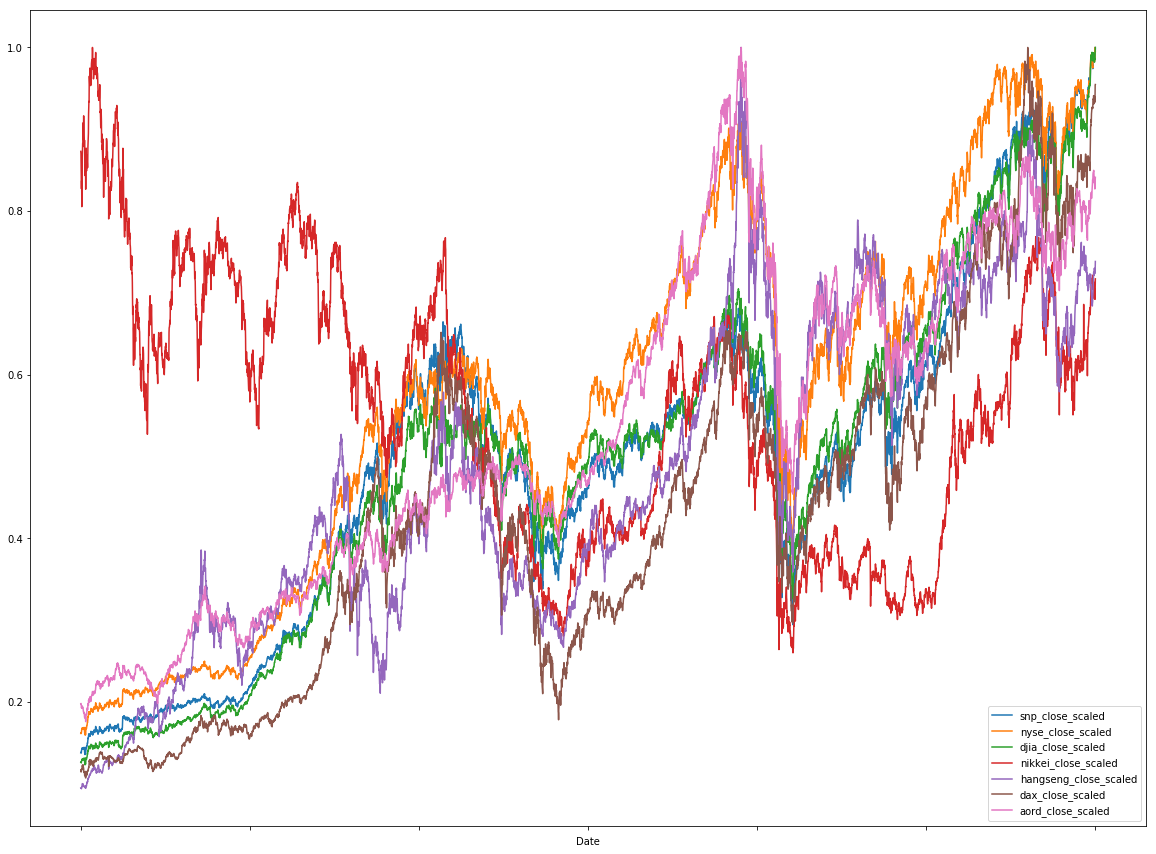

In [9]:
_ = pd.concat([closing_data['snp_close_scaled'],
  closing_data['nyse_close_scaled'],
  closing_data['djia_close_scaled'],
  closing_data['nikkei_close_scaled'],
  closing_data['hangseng_close_scaled'],
  #closing_data['ftse_close_scaled'],
  closing_data['dax_close_scaled'],
  closing_data['aord_close_scaled']], axis=1).plot(figsize=(20, 15))

You can see that, over the time period of interest, these indices are correlated. Notice that sudden drops from economic events happened globally to all indices, and they otherwise exhibited general rises. This is an good start, though not the complete story. Next, plot autocorrelations for each of the indices. The autocorrelations determine correlations between current values of the index and lagged values of the same index. The goal is to determine whether the lagged values are reliable indicators of the current values. If they are, then we've identified a correlation.

/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  """
/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  
/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  import sys
/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  
/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrela

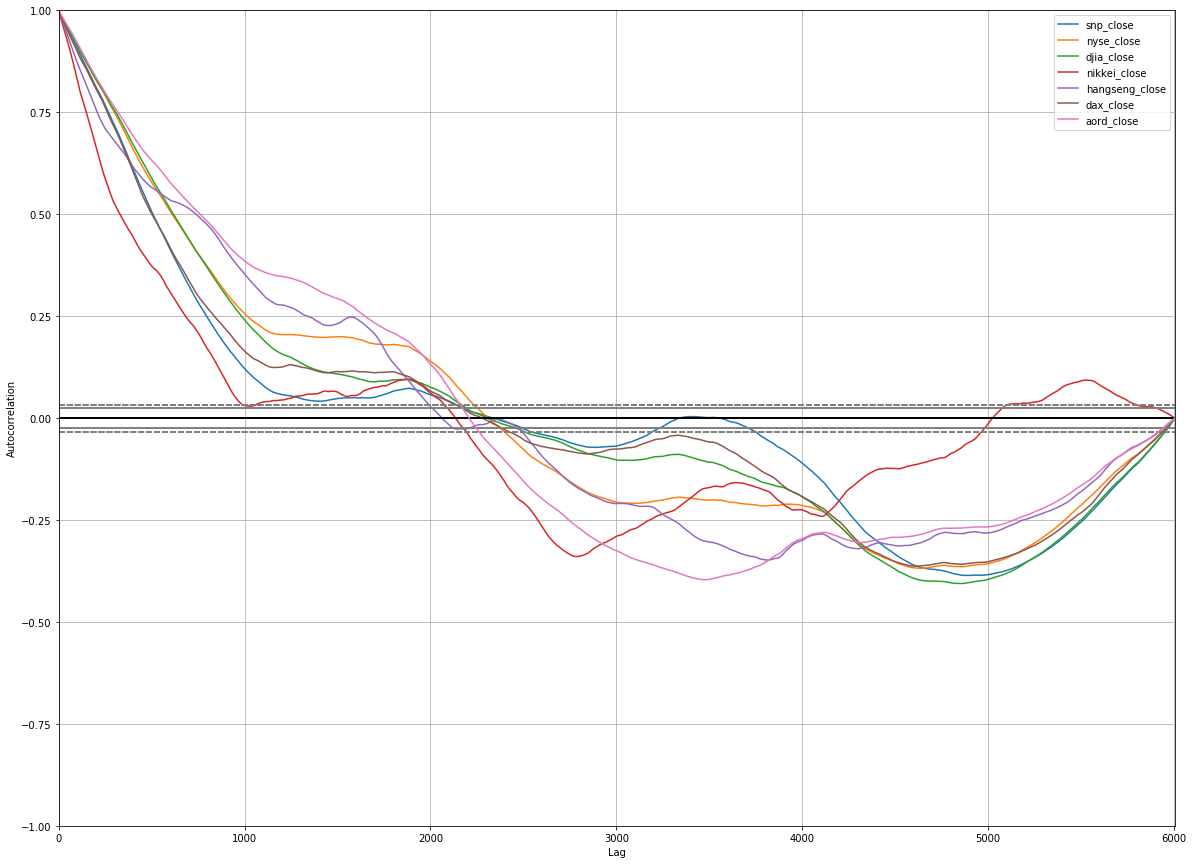

In [10]:
fig = plt.figure()
fig.set_figwidth(20)
fig.set_figheight(15)

_ = autocorrelation_plot(closing_data['snp_close'], label='snp_close')
_ = autocorrelation_plot(closing_data['nyse_close'], label='nyse_close')
_ = autocorrelation_plot(closing_data['djia_close'], label='djia_close')
_ = autocorrelation_plot(closing_data['nikkei_close'], label='nikkei_close')
_ = autocorrelation_plot(closing_data['hangseng_close'], label='hangseng_close')
#_ = autocorrelation_plot(closing_data['ftse_close'], label='ftse_close')
_ = autocorrelation_plot(closing_data['dax_close'], label='dax_close')
_ = autocorrelation_plot(closing_data['aord_close'], label='aord_close')

_ = plt.legend(loc='upper right')

You should see strong autocorrelations, positive for around 2000 lagged days, then going negative. This tells us something we should intuitively know: if an index is rising it tends to carry on rising, and vice-versa. It should be encouraging that what we see here conforms to what we know about financial markets.

Next, look at a scatter matrix, showing everything plotted against everything, to see how indices are correlated with each other.

/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  


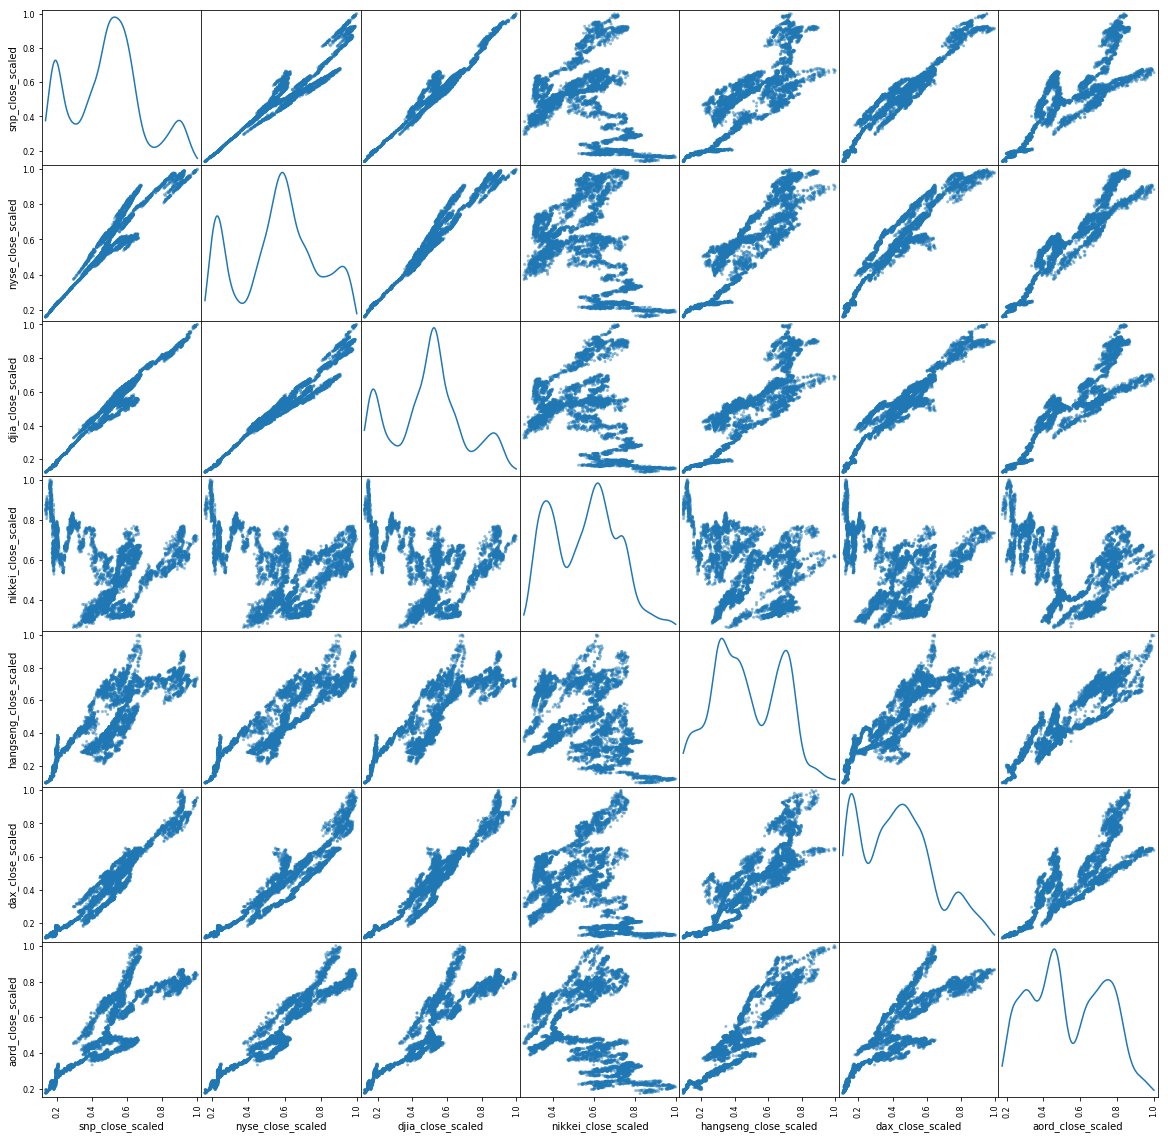

In [11]:
_ = scatter_matrix(pd.concat([closing_data['snp_close_scaled'],
  closing_data['nyse_close_scaled'],
  closing_data['djia_close_scaled'],
  closing_data['nikkei_close_scaled'],
  closing_data['hangseng_close_scaled'],
  #closing_data['ftse_close_scaled'],
  closing_data['dax_close_scaled'],
  closing_data['aord_close_scaled']], axis=1), figsize=(20, 20), diagonal='kde')

You can see significant correlations across the board, further evidence that the premise is workable and one market can be influenced by another. 

As an aside, this process of gradual, incremental experimentation and progress is the best approach and what you probably do normally. With a little patience, we'll get to some deeper understanding.

The actual value of an index is not that useful for modeling. It can be a useful indicator, but to get to the heart of the matter, we need a time series that is stationary in the mean, thus having no trend in the data. There are various ways of doing that, but they all essentially look at the difference between values, rather than the absolute value. In the case of market data, the usual practice is to work with logged returns, calculated as the natural logarithm of the index today divided by the index yesterday:

`ln(Vt/Vt-1)`

There are more reasons why the log return is preferable to the percent return (for example the log is normally distributed and additive), but they don't matter much for this work. What matters is to get to a stationary time series.

Calculate and plot the log returns in a new DataFrame.

In [12]:
log_return_data = pd.DataFrame()

log_return_data['snp_log_return'] = np.log(closing_data['snp_close']/closing_data['snp_close'].shift())
log_return_data['nyse_log_return'] = np.log(closing_data['nyse_close']/closing_data['nyse_close'].shift())
log_return_data['djia_log_return'] = np.log(closing_data['djia_close']/closing_data['djia_close'].shift())
log_return_data['nikkei_log_return'] = np.log(closing_data['nikkei_close']/closing_data['nikkei_close'].shift())
log_return_data['hangseng_log_return'] = np.log(closing_data['hangseng_close']/closing_data['hangseng_close'].shift())
#log_return_data['ftse_log_return'] = np.log(closing_data['ftse_close']/closing_data['ftse_close'].shift())
log_return_data['dax_log_return'] = np.log(closing_data['dax_close']/closing_data['dax_close'].shift())
log_return_data['aord_log_return'] = np.log(closing_data['aord_close']/closing_data['aord_close'].shift())

log_return_data.describe()

,snp_log_return,nyse_log_return,djia_log_return,nikkei_log_return,hangseng_log_return,dax_log_return,aord_log_return
count,6003.000000,6003.000000,6003.000000,6003.000000,6003.000000,6003.000000,6003.000000
mean,0.000330,0.000303,0.000345,-0.000033,0.000342,0.000350,0.000241
std,0.011727,0.011519,0.011157,0.015820,0.016829,0.015025,0.009863
min,-0.094695,-0.102321,-0.082005,-0.121110,-0.147346,-0.098709,-0.104874
25%,-0.004687,-0.004474,-0.004656,-0.008150,-0.006998,-0.006780,-0.004760
50%,0.000588,0.000583,0.000518,0.000198,0.000171,0.000880,0.000486
75%,0.005812,0.005554,0.005816,0.008506,0.008297,0.008123,0.005630
max,0.104236,0.112061,0.103259,0.132346,0.172470,0.134627,0.090232


Looking at the log returns, you should see that the mean, min, max are all similar. You could go further and center the series on zero, scale them, and normalize the standard deviation, but there's no need to do that at this point. Let's move forward with plotting the data, and iterate if necessary.

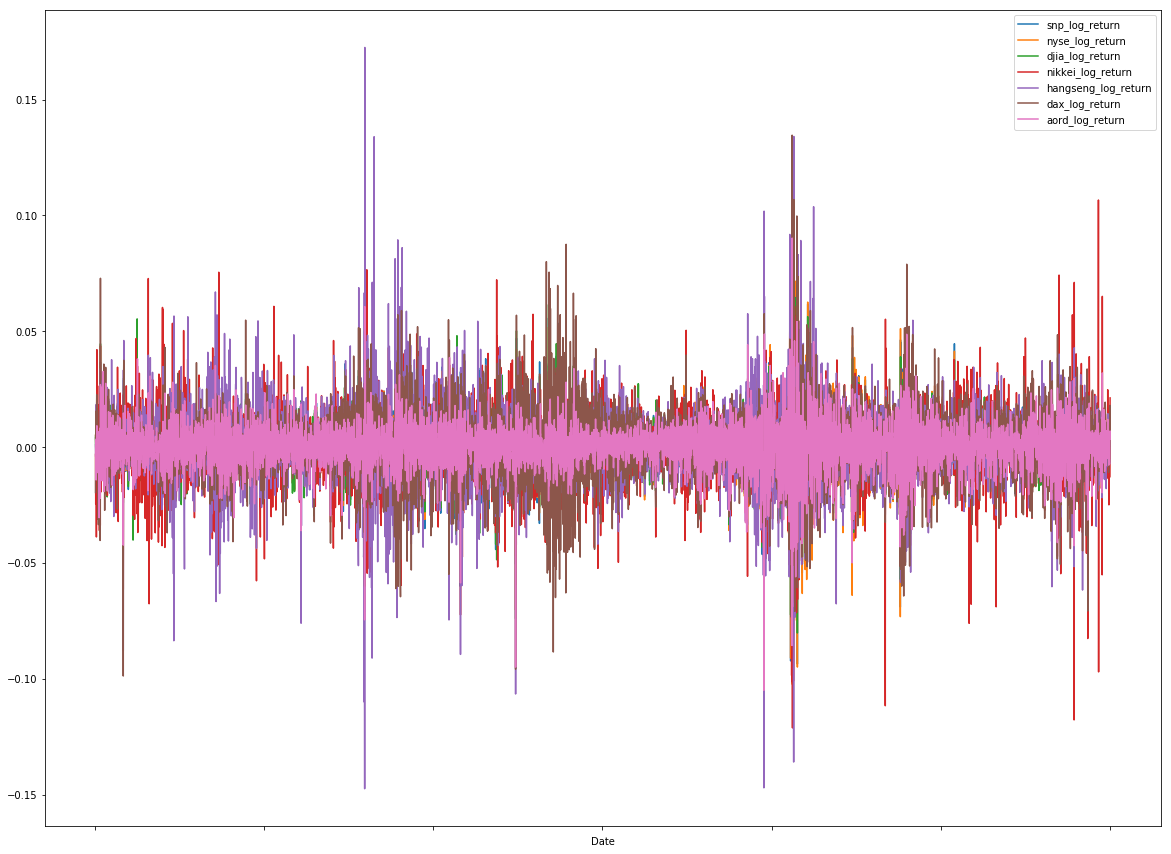

In [13]:
_ = pd.concat([log_return_data['snp_log_return'],
  log_return_data['nyse_log_return'],
  log_return_data['djia_log_return'],
  log_return_data['nikkei_log_return'],
  log_return_data['hangseng_log_return'],
  #log_return_data['ftse_log_return'],
  log_return_data['dax_log_return'],
  log_return_data['aord_log_return']], axis=1).plot(figsize=(20, 15))

You can see from the plot that the log returns of our indices are similarly scaled and centered, with no visible trend in the data. It's looking good, so now look at autocorrelations.

/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  """
/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  
/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  import sys
/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  
/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrela

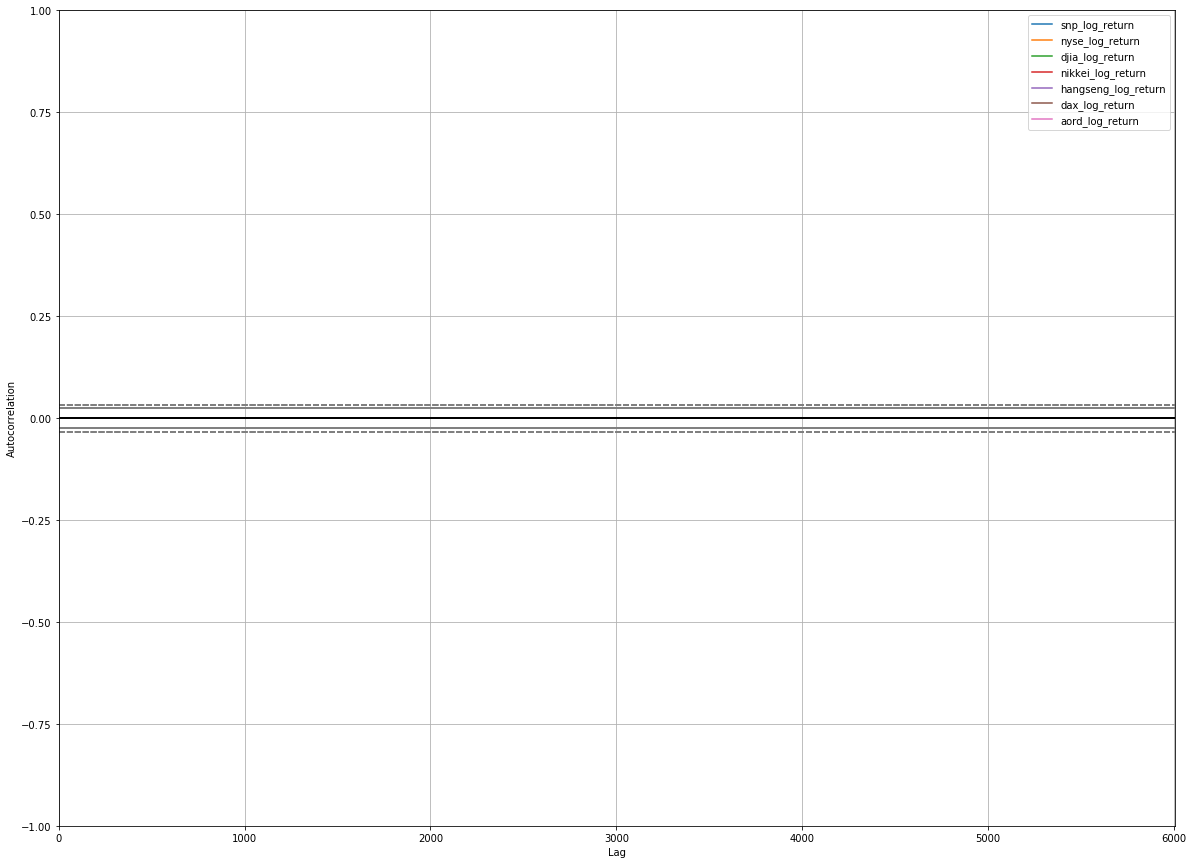

In [14]:
fig = plt.figure()
fig.set_figwidth(20)
fig.set_figheight(15)

_ = autocorrelation_plot(log_return_data['snp_log_return'], label='snp_log_return')
_ = autocorrelation_plot(log_return_data['nyse_log_return'], label='nyse_log_return')
_ = autocorrelation_plot(log_return_data['djia_log_return'], label='djia_log_return')
_ = autocorrelation_plot(log_return_data['nikkei_log_return'], label='nikkei_log_return')
_ = autocorrelation_plot(log_return_data['hangseng_log_return'], label='hangseng_log_return')
#_ = autocorrelation_plot(log_return_data['ftse_log_return'], label='ftse_log_return')
_ = autocorrelation_plot(log_return_data['dax_log_return'], label='dax_log_return')
_ = autocorrelation_plot(log_return_data['aord_log_return'], label='aord_log_return')

_ = plt.legend(loc='upper right')

No autocorrelations are visible in the plot, which is what we're looking for. Individual financial markets are Markov processes, knowledge of history doesn't allow you to predict the future. 

You now have time series for the indices, stationary in the mean, similarly centered and scaled. That's great! Now start to look for signals to try to predict the close of the S&P 500. 

Look at a scatterplot to see how the log return indices correlate with each other.

/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  """Entry point for launching an IPython kernel.


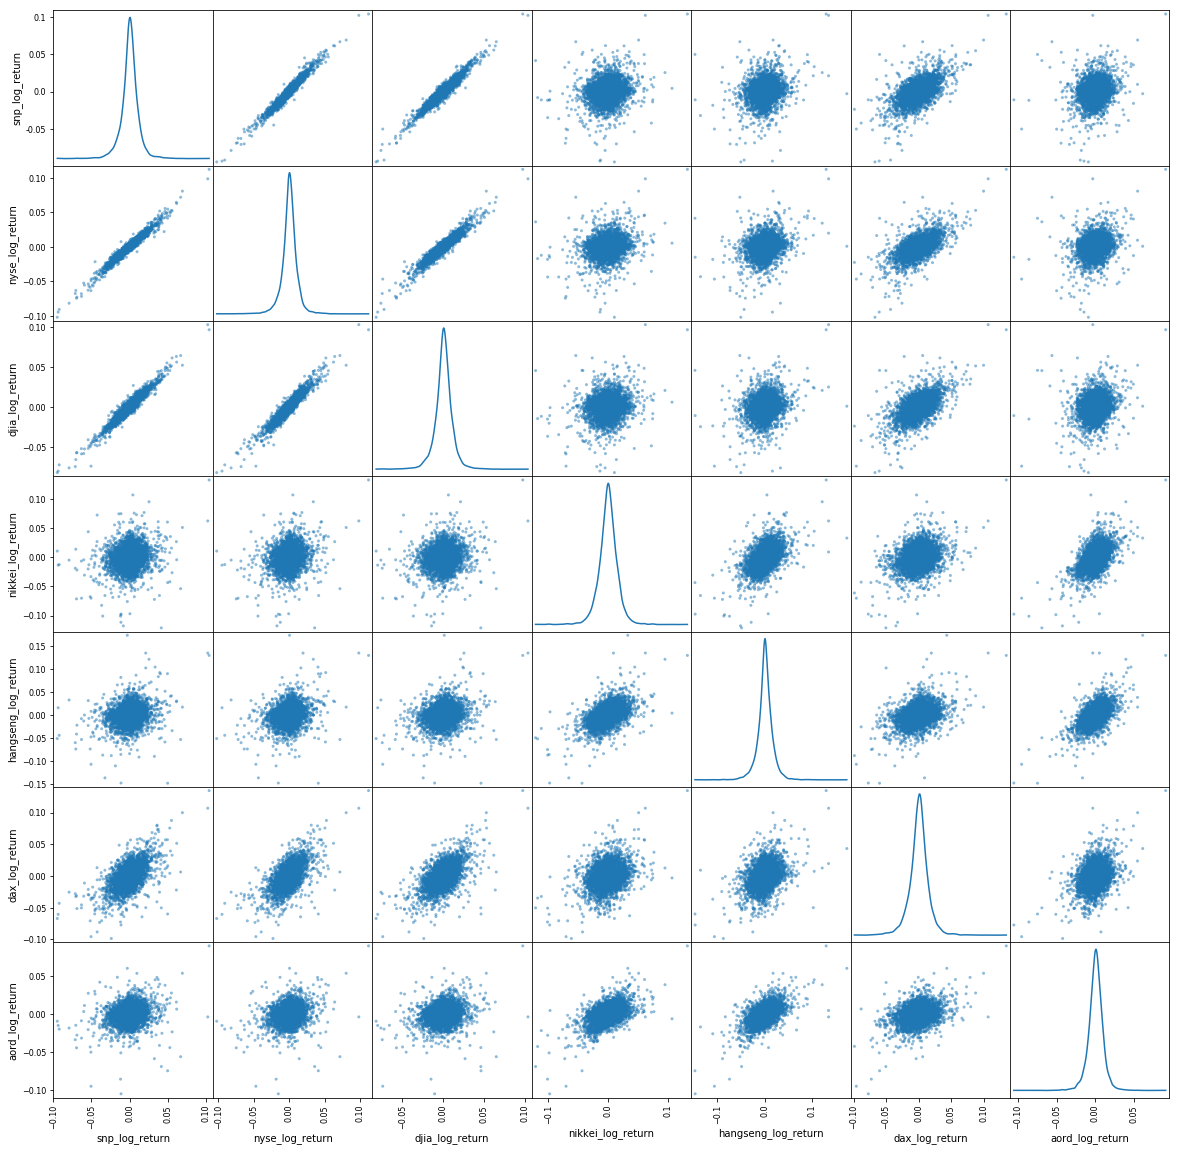

In [15]:
_ = scatter_matrix(log_return_data, figsize=(20, 20), diagonal='kde')

The story with the previous scatter plot for log returns is more subtle and more interesting. The US indices are strongly correlated, as expected. The other indices, less so, which is also expected. But there is structure and signal there. Now let's move forward and start to quantify it so we can start to choose features for our model.

First look at how the log returns for the closing value of the S&P 500 correlate with the closing values of other indices available on the same day. This essentially means to assume the indices that close before the S&P 500 (non-US indices) are available and the others (US indices) are not.

In [16]:
tmp = pd.DataFrame()
tmp['snp_0'] = log_return_data['snp_log_return']
tmp['nyse_1'] = log_return_data['nyse_log_return'].shift()
tmp['djia_1'] = log_return_data['djia_log_return'].shift()
#tmp['ftse_0'] = log_return_data['ftse_log_return']
tmp['dax_0'] = log_return_data['dax_log_return']
tmp['hangseng_0'] = log_return_data['hangseng_log_return']
tmp['nikkei_0'] = log_return_data['nikkei_log_return']
tmp['aord_0'] = log_return_data['aord_log_return']
tmp.corr().iloc[:,0]

snp_0         1.000000
nyse_1       -0.056965
djia_1       -0.059876
dax_0         0.565561
hangseng_0    0.212567
nikkei_0      0.174382
aord_0        0.184805
Name: snp_0, dtype: float64

Here, we are directly working with the premise. We're correlating the close of the S&P 500 with signals available before the close of the S&P 500.  And you can see that the S&P 500 close is correlated with European indices at around 0.56 for the DAX, which is a strong correlation, and Asian/Oceanian indices at around 0.15-0.22, which is a significant correlation, but not with US indices. We have available signals from other indices and regions for our model.

Now look at how the log returns for the S&P closing values correlate with index values from the previous day to see if they previous closing is predictive. Following from the premise that financial markets are Markov processes, there should be little or no value in historical values.

In [17]:
tmp = pd.DataFrame()
tmp['snp_0'] = log_return_data['snp_log_return']
tmp['nyse_1'] = log_return_data['nyse_log_return'].shift(2)
tmp['djia_1'] = log_return_data['djia_log_return'].shift(2)
#tmp['ftse_0'] = log_return_data['ftse_log_return'].shift()
tmp['dax_0'] = log_return_data['dax_log_return'].shift()
tmp['hangseng_0'] = log_return_data['hangseng_log_return'].shift()
tmp['nikkei_0'] = log_return_data['nikkei_log_return'].shift()
tmp['aord_0'] = log_return_data['aord_log_return'].shift()
tmp.corr().iloc[:,0]

snp_0         1.000000
nyse_1       -0.020518
djia_1       -0.018712
dax_0        -0.027795
hangseng_0   -0.037808
nikkei_0     -0.026717
aord_0       -0.040016
Name: snp_0, dtype: float64

You should see little to no correlation in this data, meaning that yesterday's values are no practical help in predicting today's close. Let's go one step further and look at correlations between today and the the day before yesterday.

In [18]:
tmp = pd.DataFrame()
tmp['snp_0'] = log_return_data['snp_log_return']
tmp['nyse_1'] = log_return_data['nyse_log_return'].shift(3)
tmp['djia_1'] = log_return_data['djia_log_return'].shift(3)
#tmp['ftse_0'] = log_return_data['ftse_log_return'].shift(2)
tmp['dax_0'] = log_return_data['dax_log_return'].shift(2)
tmp['hangseng_0'] = log_return_data['hangseng_log_return'].shift(2)
tmp['nikkei_0'] = log_return_data['nikkei_log_return'].shift(2)
tmp['aord_0'] = log_return_data['aord_log_return'].shift(2)

tmp.corr().iloc[:,0]

snp_0         1.000000
nyse_1       -0.019753
djia_1       -0.015580
dax_0        -0.022035
hangseng_0    0.005968
nikkei_0     -0.009775
aord_0       -0.004006
Name: snp_0, dtype: float64

Again, there are little to no correlations.

## Summing up the EDA

At this point, you've done a good enough job of exploratory data analysis. You've visualized our data and come to know it better. You've transformed it into a form that is useful for modelling, log returns, and looked at how indices relate to each other. You've seen that indices from Europe strongly correlate with US indices, and that indices from Asia/Oceania significantly correlate with those same indices for a given day. You've also seen that if you look at historical values, they do not correlate with today's values. Summing up:

* European indices from the same day were a strong predictor for the S&P 500 close.
* Asian/Oceanian indices from the same day were a significant predictor for the S&P 500 close.
* Indices from previous days were not good predictors for the S&P close.

What should we think so far?

With just a few lines of code, you were able to munge the data, visualize the changes, and make decisions. You could easily analyze and iterate.

## Feature selection

At this point, we can see a model:

* We'll predict whether the S&P 500 close today will be higher or lower than yesterday.
* We'll use all our data sources: NYSE, DJIA, Nikkei, Hang Seng, DAX, AORD.
* We'll use three sets of data points—T, T-1, and T-2—where we take the data available on day T or T-n, meaning today's non-US data and yesterday's US data.

Predicting whether the log return of the S&P 500 is positive or negative is a classification problem. That is, we want to choose one option from a finite set of options, in this case positive or negative. This is the base case of classification where we have only two values to choose from, known as binary classification, or logistic regression.

This uses the findings from of our exploratory data analysis, namely that log returns from other regions on a given day are strongly correlated with the log return of the S&P 500, and there are stronger correlations from those regions that are geographically closer with respect to time zones. However, our models also use data outside of those findings. For example, we use data from the past few days in addition to today.  There are two reasons for using this additional data. First, we're adding additional features to our model for the purpose of this solution to see how things perform. which is not a good reason to add features outside of a tutorial setting. Second, machine learning models are very good at finding weak signals from data.

In machine learning, as in most things, there are subtle tradeoffs happening, but in general good data is better than good algorithms, which are better than good frameworks. You need all three pillars but in that order of importance: data, algorithms, frameworks.

## TensorFlow

[TensorFlow](https://tensorflow.org) is an open source software library, initiated by Google, for numerical computation using data flow graphs. TensorFlow is based on Google's machine learning expertise and is the next generation framework used internally at Google for tasks such as translation and image recognition. It's a wonderful framework for machine learning because it's expressive, efficient, and easy to use.

### Feature engineering for TensorFlow

From a training and testing perspective, time series data is easy. Training data should come from events that happened before test data events, and be contiguous in time.  Otherwise,  your model would be trained on events from "the future", at least as compared to the test data. It would then likely perform badly in practice, because you can’t really have access to data from the future. That means random sampling or cross validation don't apply to time series data. Decide on a training-versus-testing split, and divide your data into training and test datasets.

In this case, you'll create the features together with two additional columns:

*  snp_log_return_positive, which is 1 if the log return of the S&P 500 close is positive, and 0 otherwise. 
* snp_log_return_negative, which is 1 if the log return of the S&P 500 close is negative, and 1 otherwise. 

Now, logically you could encode this information in one column, named snp_log_return, which is 1 if positive and 0 if negative, but that's not the way TensorFlow works for classification models. TensorFlow uses the general definition of classification, that there can be many different potential values to choose from, and a form or encoding for these options called one-hot encoding. One-hot encoding means that each choice is an entry in an array, and the actual value has an entry of 1 with all other values being 0. This encoding (i.e. a single 1 in an array of 0s) is for the input of the model, where you categorically know which value is correct. A variation of this is used for the output, where each entry in the array contains the probability of the answer being that choice. You can then choose the most likely value by choosing the highest probability, together with having a measure of the confidence you can place in that answer relative to other answers.

We'll use 80% of our data for training and 20% for testing.

In [19]:
log_return_data['snp_log_return_positive'] = 0
log_return_data.ix[log_return_data['snp_log_return'] >= 0, 'snp_log_return_positive'] = 1
log_return_data['snp_log_return_negative'] = 0
log_return_data.ix[log_return_data['snp_log_return'] < 0, 'snp_log_return_negative'] = 1

training_test_data = pd.DataFrame(
  columns=[
    'snp_log_return_positive', 'snp_log_return_negative',
    'snp_log_return_1', 'snp_log_return_2', 'snp_log_return_3',
    'nyse_log_return_1', 'nyse_log_return_2', 'nyse_log_return_3',
    'djia_log_return_1', 'djia_log_return_2', 'djia_log_return_3',
    'nikkei_log_return_0', 'nikkei_log_return_1', 'nikkei_log_return_2',
    'hangseng_log_return_0', 'hangseng_log_return_1', 'hangseng_log_return_2',
    #'ftse_log_return_0', 'ftse_log_return_1', 'ftse_log_return_2',
    'dax_log_return_0', 'dax_log_return_1', 'dax_log_return_2',
    'aord_log_return_0', 'aord_log_return_1', 'aord_log_return_2'])

for i in range(7, len(log_return_data)):
  snp_log_return_positive = log_return_data['snp_log_return_positive'].ix[i]
  snp_log_return_negative = log_return_data['snp_log_return_negative'].ix[i]
  snp_log_return_1 = log_return_data['snp_log_return'].ix[i-1]
  snp_log_return_2 = log_return_data['snp_log_return'].ix[i-2]
  snp_log_return_3 = log_return_data['snp_log_return'].ix[i-3]
  nyse_log_return_1 = log_return_data['nyse_log_return'].ix[i-1]
  nyse_log_return_2 = log_return_data['nyse_log_return'].ix[i-2]
  nyse_log_return_3 = log_return_data['nyse_log_return'].ix[i-3]
  djia_log_return_1 = log_return_data['djia_log_return'].ix[i-1]
  djia_log_return_2 = log_return_data['djia_log_return'].ix[i-2]
  djia_log_return_3 = log_return_data['djia_log_return'].ix[i-3]
  nikkei_log_return_0 = log_return_data['nikkei_log_return'].ix[i]
  nikkei_log_return_1 = log_return_data['nikkei_log_return'].ix[i-1]
  nikkei_log_return_2 = log_return_data['nikkei_log_return'].ix[i-2]
  hangseng_log_return_0 = log_return_data['hangseng_log_return'].ix[i]
  hangseng_log_return_1 = log_return_data['hangseng_log_return'].ix[i-1]
  hangseng_log_return_2 = log_return_data['hangseng_log_return'].ix[i-2]
  dax_log_return_0 = log_return_data['dax_log_return'].ix[i]
  dax_log_return_1 = log_return_data['dax_log_return'].ix[i-1]
  dax_log_return_2 = log_return_data['dax_log_return'].ix[i-2]
  aord_log_return_0 = log_return_data['aord_log_return'].ix[i]
  aord_log_return_1 = log_return_data['aord_log_return'].ix[i-1]
  aord_log_return_2 = log_return_data['aord_log_return'].ix[i-2]
  training_test_data = training_test_data.append(
    {'snp_log_return_positive':snp_log_return_positive,
    'snp_log_return_negative':snp_log_return_negative,
    'snp_log_return_1':snp_log_return_1,
    'snp_log_return_2':snp_log_return_2,
    'snp_log_return_3':snp_log_return_3,
    'nyse_log_return_1':nyse_log_return_1,
    'nyse_log_return_2':nyse_log_return_2,
    'nyse_log_return_3':nyse_log_return_3,
    'djia_log_return_1':djia_log_return_1,
    'djia_log_return_2':djia_log_return_2,
    'djia_log_return_3':djia_log_return_3,
    'nikkei_log_return_0':nikkei_log_return_0,
    'nikkei_log_return_1':nikkei_log_return_1,
    'nikkei_log_return_2':nikkei_log_return_2,
    'hangseng_log_return_0':hangseng_log_return_0,
    'hangseng_log_return_1':hangseng_log_return_1,
    'hangseng_log_return_2':hangseng_log_return_2,
    'dax_log_return_0':dax_log_return_0,
    'dax_log_return_1':dax_log_return_1,
    'dax_log_return_2':dax_log_return_2,
    'aord_log_return_0':aord_log_return_0,
    'aord_log_return_1':aord_log_return_1,
    'aord_log_return_2':aord_log_return_2},
    ignore_index=True)
  
training_test_data.describe()

/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: 
.ix is deprecated. 

,snp_log_return_positive,snp_log_return_negative,snp_log_return_1,snp_log_return_2,snp_log_return_3,nyse_log_return_1,nyse_log_return_2,nyse_log_return_3,djia_log_return_1,djia_log_return_2,...,nikkei_log_return_2,hangseng_log_return_0,hangseng_log_return_1,hangseng_log_return_2,dax_log_return_0,dax_log_return_1,dax_log_return_2,aord_log_return_0,aord_log_return_1,aord_log_return_2
count,5997.000000,5997.000000,5997.000000,5997.000000,5997.000000,5997.000000,5997.000000,5997.000000,5997.000000,5997.000000,...,5997.000000,5997.000000,5997.000000,5997.000000,5997.000000,5997.000000,5997.000000,5997.000000,5997.000000,5997.000000
mean,0.537769,0.462231,0.000327,0.000326,0.000328,0.000300,0.000300,0.000302,0.000343,0.000342,...,-0.000030,0.000341,0.000339,0.000341,0.000350,0.000348,0.000348,0.000246,0.000244,0.000244
std,0.498613,0.498613,0.011730,0.011730,0.011732,0.011522,0.011522,0.011524,0.011160,0.011160,...,0.015819,0.016836,0.016835,0.016837,0.015027,0.015027,0.015027,0.009865,0.009865,0.009865
min,0.000000,0.000000,-0.094695,-0.094695,-0.094695,-0.102321,-0.102321,-0.102321,-0.082005,-0.082005,...,-0.121110,-0.147346,-0.147346,-0.147346,-0.098709,-0.098709,-0.098709,-0.104874,-0.104874,-0.104874
25%,0.000000,0.000000,-0.004687,-0.004687,-0.004687,-0.004476,-0.004476,-0.004476,-0.004657,-0.004657,...,-0.008139,-0.007003,-0.007003,-0.007003,-0.006779,-0.006781,-0.006781,-0.004751,-0.004754,-0.004754
50%,1.000000,0.000000,0.000588,0.000588,0.000588,0.000583,0.000583,0.000583,0.000516,0.000516,...,0.000200,0.000173,0.000171,0.000171,0.000880,0.000880,0.000880,0.000496,0.000486,0.000486
75%,1.000000,1.000000,0.005811,0.005811,0.005811,0.005553,0.005553,0.005553,0.005817,0.005815,...,0.008505,0.008299,0.008296,0.008299,0.008123,0.008123,0.008123,0.005636,0.005633,0.005633
max,1.000000,1.000000,0.104236,0.104236,0.104236,0.112061,0.112061,0.112061,0.103259,0.103259,...,0.132346,0.172470,0.172470,0.172470,0.134627,0.134627,0.134627,0.090232,0.090232,0.090232


Now, create the training and test data.

In [20]:
predictors_tf = training_test_data[training_test_data.columns[2:]]

classes_tf = training_test_data[training_test_data.columns[:2]]

training_set_size = int(len(training_test_data) * 0.8)
test_set_size = len(training_test_data) - training_set_size

training_predictors_tf = predictors_tf[:training_set_size]
training_classes_tf = classes_tf[:training_set_size]
test_predictors_tf = predictors_tf[training_set_size:]
test_classes_tf = classes_tf[training_set_size:]

training_predictors_tf.describe()

,snp_log_return_1,snp_log_return_2,snp_log_return_3,nyse_log_return_1,nyse_log_return_2,nyse_log_return_3,djia_log_return_1,djia_log_return_2,djia_log_return_3,nikkei_log_return_0,...,nikkei_log_return_2,hangseng_log_return_0,hangseng_log_return_1,hangseng_log_return_2,dax_log_return_0,dax_log_return_1,dax_log_return_2,aord_log_return_0,aord_log_return_1,aord_log_return_2
count,4797.000000,4797.000000,4797.000000,4797.000000,4797.000000,4797.000000,4797.000000,4797.000000,4797.000000,4797.000000,...,4797.000000,4797.000000,4797.000000,4797.000000,4797.000000,4797.000000,4797.000000,4797.000000,4797.000000,4797.000000
mean,0.000272,0.000266,0.000272,0.000280,0.000274,0.000280,0.000311,0.000306,0.000310,-0.000191,...,-0.000200,0.000376,0.000374,0.000373,0.000296,0.000290,0.000286,0.000245,0.000245,0.000243
std,0.012328,0.012318,0.012320,0.012014,0.012005,0.012006,0.011732,0.011726,0.011728,0.015853,...,0.015861,0.017832,0.017831,0.017830,0.015477,0.015475,0.015469,0.010080,0.010080,0.010078
min,-0.094695,-0.094695,-0.094695,-0.102321,-0.102321,-0.102321,-0.082005,-0.082005,-0.082005,-0.121110,...,-0.121110,-0.147346,-0.147346,-0.147346,-0.098709,-0.098709,-0.098709,-0.104874,-0.104874,-0.104874
25%,-0.005126,-0.005126,-0.005118,-0.004557,-0.004557,-0.004557,-0.005025,-0.005025,-0.005025,-0.008438,...,-0.008440,-0.007329,-0.007329,-0.007329,-0.007029,-0.007036,-0.007036,-0.004751,-0.004751,-0.004751
50%,0.000598,0.000598,0.000603,0.000589,0.000589,0.000591,0.000518,0.000518,0.000519,0.000038,...,0.000038,0.000175,0.000173,0.000173,0.000804,0.000795,0.000795,0.000460,0.000460,0.000460
75%,0.006012,0.005992,0.006012,0.005618,0.005618,0.005619,0.005999,0.005994,0.005999,0.008390,...,0.008390,0.008779,0.008769,0.008769,0.008249,0.008246,0.008246,0.005627,0.005627,0.005623
max,0.104236,0.104236,0.104236,0.112061,0.112061,0.112061,0.103259,0.103259,0.103259,0.132346,...,0.132346,0.172470,0.172470,0.172470,0.134627,0.134627,0.134627,0.090232,0.090232,0.090232


In [21]:
test_predictors_tf.describe()

,snp_log_return_1,snp_log_return_2,snp_log_return_3,nyse_log_return_1,nyse_log_return_2,nyse_log_return_3,djia_log_return_1,djia_log_return_2,djia_log_return_3,nikkei_log_return_0,...,nikkei_log_return_2,hangseng_log_return_0,hangseng_log_return_1,hangseng_log_return_2,dax_log_return_0,dax_log_return_1,dax_log_return_2,aord_log_return_0,aord_log_return_1,aord_log_return_2
count,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,...,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000
mean,0.000545,0.000566,0.000554,0.000383,0.000404,0.000390,0.000470,0.000487,0.000481,0.000667,...,0.000651,0.000202,0.000200,0.000216,0.000565,0.000583,0.000595,0.000251,0.000241,0.000250
std,0.008953,0.009003,0.009005,0.009303,0.009350,0.009353,0.008501,0.008535,0.008534,0.015644,...,0.015638,0.012065,0.012063,0.012082,0.013075,0.013089,0.013113,0.008958,0.008957,0.008967
min,-0.040211,-0.040211,-0.040211,-0.043961,-0.043961,-0.043961,-0.036402,-0.036402,-0.036402,-0.117658,...,-0.117658,-0.061621,-0.061621,-0.061621,-0.070673,-0.070673,-0.070673,-0.042477,-0.042477,-0.042477
25%,-0.003617,-0.003617,-0.003625,-0.004222,-0.004222,-0.004246,-0.003595,-0.003595,-0.003595,-0.006771,...,-0.006771,-0.006046,-0.006046,-0.006046,-0.006111,-0.006111,-0.006111,-0.004736,-0.004759,-0.004759
50%,0.000543,0.000543,0.000535,0.000543,0.000543,0.000532,0.000511,0.000511,0.000498,0.000816,...,0.000799,0.000115,0.000115,0.000115,0.001114,0.001120,0.001120,0.000587,0.000576,0.000576
75%,0.005139,0.005139,0.005124,0.005379,0.005379,0.005363,0.005026,0.005026,0.005016,0.008985,...,0.008952,0.006702,0.006702,0.006773,0.007391,0.007392,0.007392,0.005642,0.005637,0.005642
max,0.044652,0.044652,0.044652,0.045762,0.045762,0.045762,0.041533,0.041533,0.041533,0.106654,...,0.106654,0.054778,0.054778,0.054778,0.052104,0.052104,0.052104,0.032049,0.032049,0.032049


Define some metrics here to evaluate the models.

* [Precision](https://en.wikipedia.org/wiki/Precision_and_recall#Precision) -  The ability of the classifier not to label as positive a sample that is negative.
* [Recall](https://en.wikipedia.org/wiki/Precision_and_recall#Recall) - The ability of the classifier to find all the positive samples.
* [F1 Score](https://en.wikipedia.org/wiki/F1_score) - A weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0.
* Accuracy - The percentage correctly predicted in the test data.

In [22]:
def tf_confusion_metrics(model, actual_classes, session, feed_dict):
  predictions = tf.argmax(model, 1)
  actuals = tf.argmax(actual_classes, 1)

  ones_like_actuals = tf.ones_like(actuals)
  zeros_like_actuals = tf.zeros_like(actuals)
  ones_like_predictions = tf.ones_like(predictions)
  zeros_like_predictions = tf.zeros_like(predictions)

  tp_op = tf.reduce_sum(
    tf.cast(
      tf.logical_and(
        tf.equal(actuals, ones_like_actuals), 
        tf.equal(predictions, ones_like_predictions)
      ), 
      "float"
    )
  )

  tn_op = tf.reduce_sum(
    tf.cast(
      tf.logical_and(
        tf.equal(actuals, zeros_like_actuals), 
        tf.equal(predictions, zeros_like_predictions)
      ), 
      "float"
    )
  )

  fp_op = tf.reduce_sum(
    tf.cast(
      tf.logical_and(
        tf.equal(actuals, zeros_like_actuals), 
        tf.equal(predictions, ones_like_predictions)
      ), 
      "float"
    )
  )

  fn_op = tf.reduce_sum(
    tf.cast(
      tf.logical_and(
        tf.equal(actuals, ones_like_actuals), 
        tf.equal(predictions, zeros_like_predictions)
      ), 
      "float"
    )
  )

  tp, tn, fp, fn = \
    session.run(
      [tp_op, tn_op, fp_op, fn_op], 
      feed_dict
    )

  tpr = float(tp)/(float(tp) + float(fn))
  fpr = float(fp)/(float(tp) + float(fn))

  accuracy = (float(tp) + float(tn))/(float(tp) + float(fp) + float(fn) + float(tn))

  recall = tpr
  precision = float(tp)/(float(tp) + float(fp))
  
  f1_score = (2 * (precision * recall)) / (precision + recall)
  
  print 'Precision = ', precision
  print 'Recall = ', recall
  print 'F1 Score = ', f1_score
  print 'Accuracy = ', accuracy

### Binary classification with TensorFlow

Now, get some tensors flowing. The model is binary classification expressed in TensorFlow.

In [23]:
log_device_placement = True
sess = tf.Session(config=tf.ConfigProto(log_device_placement=log_device_placement))

with tf.device('/gpu:0'):
    # Define variables for the number of predictors and number of classes to remove magic numbers from our code.
    num_predictors = len(training_predictors_tf.columns) # 24 in the default case
    num_classes = len(training_classes_tf.columns) # 2 in the default case

    # Define placeholders for the data we feed into the process - feature data and actual classes.
    feature_data = tf.placeholder("float", [None, num_predictors])
    actual_classes = tf.placeholder("float", [None, num_classes])

    # Define a matrix of weights and initialize it with some small random values.
    weights = tf.Variable(tf.truncated_normal([num_predictors, num_classes], stddev=0.0001))
    biases = tf.Variable(tf.ones([num_classes]))

    # Define our model...
    # Here we take a softmax regression of the product of our feature data and weights.
    model = tf.nn.softmax(tf.matmul(feature_data, weights) + biases)

    # Define a cost function (we're using the cross entropy).
    cost = -tf.reduce_sum(actual_classes*tf.log(model))

    # Define a training step...
    # Here we use gradient descent with a learning rate of 0.01 using the cost function we just defined.
    training_step = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost)

    init = tf.initialize_all_variables()
    sess.run(init)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


We'll train our model in the following snippet. The approach of TensorFlow to executing graph operations allows fine-grained control over the process. Any operation you provide to the session as part of the run operation will be executed and the results returned. You can provide a list of multiple operations.

You'll train the model over 30,000 iterations using the full dataset each time. Every thousandth iteration we'll assess the accuracy of the model on the training data to assess progress.

The command "with tf.device('/gpu:0')" tell TensorFlow to execute all the operations within the block on the availabel GPU (NVIDIA P100).

In [24]:
with tf.device('/gpu:0'):
    correct_prediction = tf.equal(tf.argmax(model, 1), tf.argmax(actual_classes, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

    for i in range(1, 30001):
      sess.run(
        training_step, 
        feed_dict={
          feature_data: training_predictors_tf.values, 
          actual_classes: training_classes_tf.values.reshape(len(training_classes_tf.values), 2)
        }
      )
      if i%5000 == 0:
        print i, sess.run(
          accuracy,
          feed_dict={
            feature_data: training_predictors_tf.values, 
            actual_classes: training_classes_tf.values.reshape(len(training_classes_tf.values), 2)
          }
        )

5000 0.539295
10000 0.555764
15000 0.570773
20000 0.582447
25000 0.594538
30000 0.59975


In [25]:
feed_dict= {
  feature_data: test_predictors_tf.values,
  actual_classes: test_classes_tf.values.reshape(len(test_classes_tf.values), 2)
}

tf_confusion_metrics(model, actual_classes, sess, feed_dict)

Precision =  0.726495726496
Recall =  0.313075506446
F1 Score =  0.43758043758
Accuracy =  0.635833333333


An accuracy of ~64% on the training data is fine, certainly better than random.The metrics for this most simple of TensorFlow models are unimpressive, an F1 Score of 0.43 is not going to blow any light bulbs in the room. That's partly because of its simplicity and partly because It hasn't been tuned; selection of hyperparameters is very important in machine learning modelling.

### Feed-forward neural network with two hidden layers

You'll now build a proper feed-forward neural net with two hidden layers.

In [34]:
# Processing Units logs
log_device_placement = True
saver = tf.train.Saver()

sess1 = tf.Session(config=tf.ConfigProto(log_device_placement=log_device_placement))
with tf.device('/gpu:0'):
    num_predictors = len(training_predictors_tf.columns)
    num_classes = len(training_classes_tf.columns)

    feature_data = tf.placeholder("float", [None, num_predictors], name="input")
    actual_classes = tf.placeholder("float", [None, 2])

    weights1 = tf.Variable(tf.truncated_normal([21, 50], stddev=0.0001))
    biases1 = tf.Variable(tf.ones([50]))

    weights2 = tf.Variable(tf.truncated_normal([50, 21], stddev=0.0001))
    biases2 = tf.Variable(tf.ones([21]))
                     
    weights3 = tf.Variable(tf.truncated_normal([21, 2], stddev=0.0001))
    biases3 = tf.Variable(tf.ones([2]))

    hidden_layer_1 = tf.nn.relu(tf.matmul(feature_data, weights1) + biases1)
    hidden_layer_2 = tf.nn.relu(tf.matmul(hidden_layer_1, weights2) + biases2)
    model = tf.nn.softmax(tf.matmul(hidden_layer_2, weights3) + biases3, name="model")
    
    cost = -tf.reduce_sum(actual_classes*tf.log(model))
    
    train_op1 = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost)

    init = tf.initialize_all_variables()
    sess1.run(init)

Again, you'll train the model over 30,000 iterations using the full dataset each time running completely on the P100 GPU. Every thousandth iteration, you'll assess the accuracy of the model on the training data to assess progress.

In [39]:
from tensorflow.python.framework import graph_util
from tensorflow.python.platform import gfile

with tf.device('/gpu:0'):
    correct_prediction = tf.equal(tf.argmax(model, 1), tf.argmax(actual_classes, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

    t1_1 = datetime.datetime.now()
    for i in range(1, 30001):
      sess1.run(
        train_op1, 
        feed_dict={
          feature_data: training_predictors_tf.values, 
          actual_classes: training_classes_tf.values.reshape(len(training_classes_tf.values), 2)
        }
      )
      if i%5000 == 0:
        print i, sess1.run(
          accuracy,
          feed_dict={
            feature_data: training_predictors_tf.values, 
            actual_classes: training_classes_tf.values.reshape(len(training_classes_tf.values), 2)
          }
        )
        
    graph = sess1.graph
    graph_file_name = '/home/joe/series/model.pb'

    output_graph_def = graph_util.convert_variables_to_constants(
      sess1, graph.as_graph_def(), ['model'])

    with gfile.FastGFile(graph_file_name, 'wb') as f:
        f.write(output_graph_def.SerializeToString())

    print("Model saved in path: %s" % graph_file_name)
    t2_1 = datetime.datetime.now()

5000 0.658953
10000 0.658953
15000 0.658953
20000 0.658953
25000 0.658953
30000 0.658953
INFO:tensorflow:Froze 6 variables.
Converted 6 variables to const ops.
Model saved in path: /home/joe/series/model.pb


In [28]:
print "Training time: " + str(t2_1-t1_1)

Training time: 0:00:43.011373


An improvement in accuracy (see below) with the training data shows that the hidden layers are adding additional capacity for learning to the model.

Looking at precision, recall, and accuracy, you can see a measurable improvement in performance, but certainly not a [step function](https://wikipedia.org/wiki/Step_function). This indicates that we're likely reaching the limits of this relatively simple feature set.

In [29]:
feed_dict= {
  feature_data: test_predictors_tf.values,
  actual_classes: test_classes_tf.values.reshape(len(test_classes_tf.values), 2)
}

tf_confusion_metrics(model, actual_classes, sess1, feed_dict)

Precision =  0.737777777778
Recall =  0.611418047882
F1 Score =  0.668680765358
Accuracy =  0.725833333333


In [40]:
def load_graph(model_file):
    graph = tf.Graph()
    graph_def = tf.GraphDef()

    with open(model_file, "rb") as f:
        graph_def.ParseFromString(f.read())
    with graph.as_default():
        tf.import_graph_def(graph_def)

    return graph

In [49]:
model_file = "/home/joe/series/model.pb"
input_layer = "import/input"
output_layer = "import/model"

graph = load_graph(model_file)
#print(graph.get_operations())
input_operation = graph.get_operation_by_name(input_layer)
output_operation = graph.get_operation_by_name(output_layer)

with tf.device('/gpu:0'):
    with tf.Session(graph=graph) as sess:
        results = sess.run(output_operation.outputs[0], {
                input_operation.outputs[0]: training_predictors_tf[:1]
            })
        results = np.squeeze(results)

        print(results , " : ", training_classes_tf.values[:1])

(array([ 0.67214417,  0.3278558 ], dtype=float32), ' : ', array([[ 1.,  0.]]))


## Conclusion

You've covered a lot of ground. You moved from sourcing five years of financial time-series data, to munging that data into a more suitable form. You explored and visualized that data with exploratory data analysis and then decided on a machine learning model and the features for that model. You engineered those features, built a binary classifier in TensorFlow, and analyzed its performance. You built a feed forward neural net with two hidden layers in TensorFlow and analyzed its performance.

How did the technology fare? It should take most people 1.5 to 3 hours to extract the juice from this solution, and none of that time is spent waiting for infrastructure or software; it's spent reading and thinking. In many organizations, it can take anywhere from days to months to do this sort of data analysis, depending on whether you need to procure any hardware. It was also cost effective. 

iPython/Jupyter has always been a great platform for interactive, iterative work and a fully-managed version of that platform, is a force multiplier for your analysis needs.  

TensorFlow is expressive, performs well, and comes with the weight of Google's machine learning history and expertise to back it up and support it. We've only scratched the surface, but you can already see that within a handful of lines of code we've been able to write two models. Neither of them is cutting edge, by design, but neither of them is trivial either. With some additional tuning they would suit a whole spectrum of machine learning tasks. 

Finally, how did we do with the data analysis? We did well: over 70% accuracy in predicting the close of the S&P 500 is the highest we've seen achieved on this dataset, so with few steps and a few lines of code we've produced a full-on machine learning model. The reason for the relatively modest accuracy achieved is the dataset itself; there isn't enough signal there to do significantly better. But 7 times out of 10, we were able to correctly determine if the S&P 500 index would close up or down on the day, and that's objectively good.

In [30]:
print '''
Copyright 2016, Google, Inc.
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
'''


Copyright 2016, Google, Inc.
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

